In [1]:
import PIL
import os
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Подготовка датасета

In [2]:
data_dir = './data'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation']
Train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Validation Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [4]:
batch_size = 200
best_model = 0
result_dir = './photos'
print(os.listdir(result_dir))
result_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

[]


In [5]:
result_ds = [result_tfms(PIL.Image.open('./photos/'+path).resize((48, 48)))for path in os.listdir(result_dir)]

In [6]:
print(result_ds[0].shape)

IndexError: list index out of range

In [12]:
print(result_ds[0])

IndexError: list index out of range

In [13]:
result_dl = DataLoader(result_ds, batch_size, num_workers=3, pin_memory=True)

In [14]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

In [42]:
print(train_ds[0])

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)


In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [17]:
def show_res_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:3], nrow=3).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


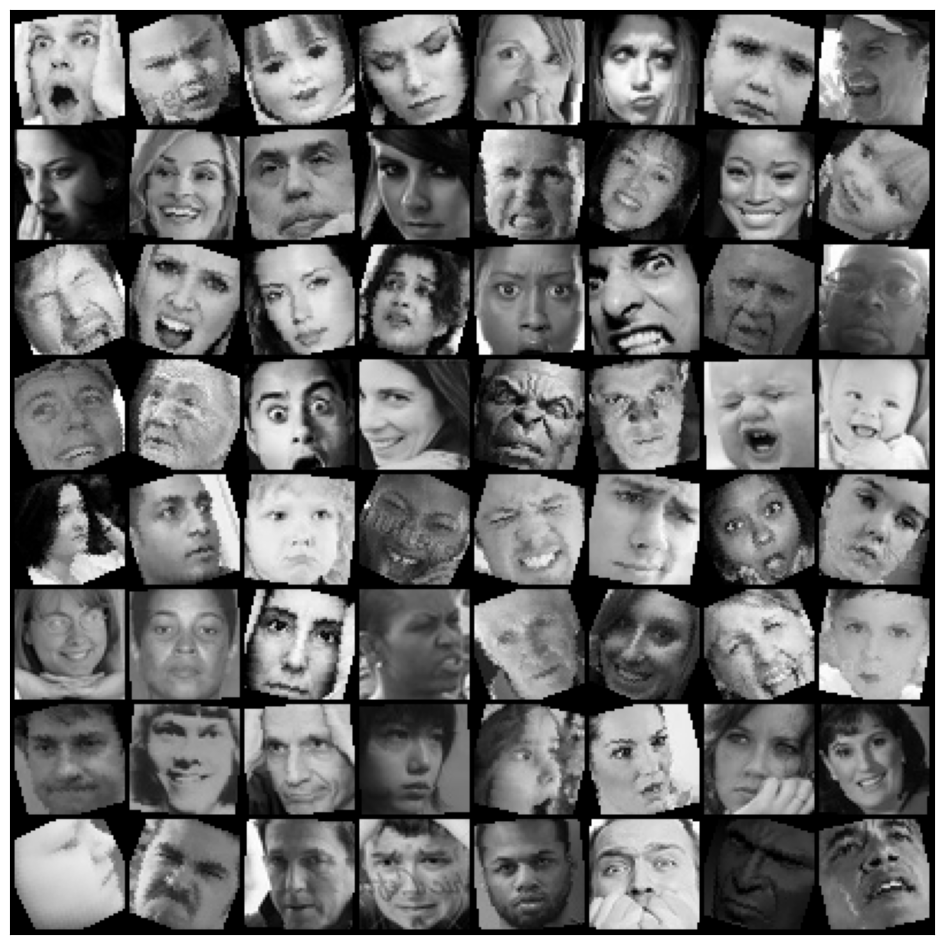

In [18]:
show_batch(train_dl)

torch.Size([1, 48, 48])


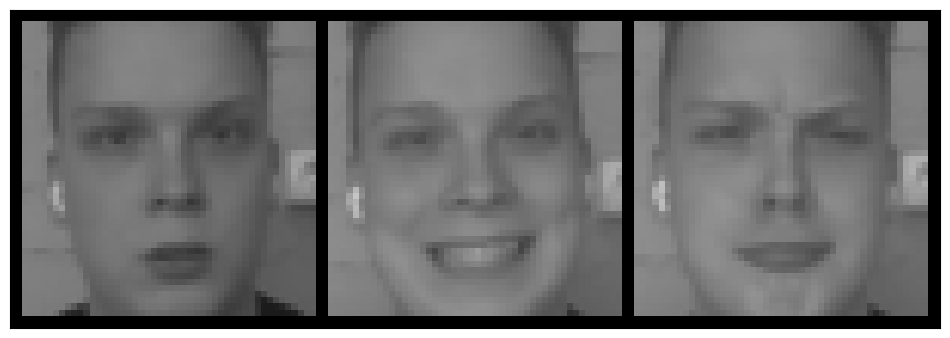

In [20]:
show_res_batch(result_dl)

## Cuda

In [19]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [20]:
device = get_default_device()
device
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


In [21]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [22]:
result_dl = DeviceDataLoader(result_dl, device)

## Шаги обучения


In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def pred_step(self, batch):
        images = batch 
        out = self(images)
        return out
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        global best_model, new_model
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        new_model = result['val_acc']
        if new_model > best_model:
            best_model = new_model
            torch.save(model.state_dict(), './models/emotion_detection_acc'+str(best_model)+'.pth')
            print('save ', './models/emotion_detection_acc'+str(best_model)+'.pth')

## Архитектура модели


In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        xb = to_device(xb,device)
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [82]:
model = to_device(ResNet(1, len(classes_train)), device)

In [25]:
model = ResNet(1, len(classes_train))
model.load_state_dict(torch.load('./models/emotion_detection_acc0.5452366471290588.pth'))
model = to_device(model,device)

In [26]:
first_parameter = next(model.parameters())
input_shape = first_parameter.size()
print(input_shape)

torch.Size([128, 1, 3, 3])


## Обучение



In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def predict(model, pred_loader):
    model.eval()
    outputs = [model.pred_step(batch) for batch in pred_loader]
    return [torch.max(el, dim=1)[1] for el in outputs]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [86]:
history = [evaluate(model, valid_dl)]

In [29]:
predicts = predict(model,result_dl)[0]

In [30]:
super_res = [classes_train[idx] for idx in predicts]

In [31]:
print(super_res)

['neutral', 'happy', 'sad']


In [50]:
print(predicts[0])

tensor([4, 3, 5], device='cuda:0')


In [87]:
print(history)

[{'val_loss': 1.2196050882339478, 'val_acc': 0.5452366471290588}]


In [28]:
epochs = 130
max_lr = 0.0008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

## Графики

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy by epochs');

In [ ]:
plot_accuracies(history)

## Saving the Model



In [ ]:
torch.save(model.state_dict(), './models/emotion_detection_3.pth')

## Model Pruning



In [33]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch_pruning as tp

In [34]:
DG = tp.DependencyGraph().build_dependency(model, example_inputs=torch.randn(1,1,48,48))

In [35]:
for group in DG.get_all_groups(ignored_layers=[model.conv1], root_module_types=[nn.Conv2d, nn.Linear]):
    # handle groups in sequential order
    idxs = [2,4,6] # your pruning indices
    group.prune(idxs=idxs)
    print(group)


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on classifier.2 (Linear(in_features=509, out_features=1, bias=True)) => prune_out_channels on classifier.2 (Linear(in_features=509, out_features=1, bias=True)), #idxs=4
--------------------------------


--------------------------------
          Pruning Group
--------------------------------
[0] prune_out_channels on conv6.0 (Conv2d(509, 506, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))) => prune_out_channels on conv6.0 (Conv2d(509, 506, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), #idxs=509
[1] prune_out_channels on conv6.0 (Conv2d(509, 506, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))) => prune_out_channels on conv6.1 (BatchNorm2d(506, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), #idxs=509
[2] prune_out_channels on conv6.1 (BatchNorm2d(506, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)) => prune_out_channels on _

In [57]:
imp = tp.importance.GroupTaylorImportance()
ignored_layers = []
for m in model.modules():
    if isinstance(m, torch.nn.Linear) and m.out_features == 4:
        ignored_layers.append(m)

In [1]:
example_inputs = torch.randn(1, 1, 48, 48)

pruner = tp.pruner.MetaPruner( # We can always choose MetaPruner if sparse training is not required.
    model,
    example_inputs,
    importance=imp,
    pruning_ratio=0.5, # remove 50% channels, ResNet18 = {64, 128, 256, 512} => ResNet18_Half = {32, 64, 128, 256}
    # pruning_ratio_dict = {model.conv1: 0.2, model.layer2: 0.8}, # customized pruning ratios for layers or blocks
    ignored_layers=ignored_layers,
)


NameError: name 'torch' is not defined

In [2]:
print(example_inputs)

NameError: name 'example_inputs' is not defined

In [58]:
print(ignored_layers)

[]


In [59]:
optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

In [ ]:
prune_epochs = 3
for epoch in range(prune_epochs):
        # Training Phase 
        model.train()
        
        pruner.update_regularizer() 
        
        train_losses = []
        lrs = []
        for batch in train_dl:
            batch = to_device(batch,device)
            loss = model.training_step(batch)
            loss.backward()
            print(4)
            pruner.regularize(model)
            print(5)
            
            
            optimizer.step()
            optimizer.zero_grad()
            print(6)
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        
        model.epoch_end(epoch, result)
    


In [38]:
module = model.conv1
print(list(module.named_parameters()))

[('0.weight', Parameter containing:
tensor([[[[ 0.0341, -0.1946,  0.1921],
          [ 0.0708,  0.1105,  0.2347],
          [ 0.0750, -0.2713,  0.0209]]],


        [[[ 0.1754, -0.1578, -0.2486],
          [-0.0485,  0.1319, -0.0473],
          [ 0.0692, -0.1877, -0.2606]]],


        [[[ 0.2975, -0.0075,  0.0908],
          [-0.2066,  0.0046,  0.2990],
          [-0.2626, -0.1841, -0.0589]]],


        ...,


        [[[ 0.2509,  0.2237, -0.2216],
          [-0.2208, -0.0127, -0.0669],
          [-0.0583, -0.1377,  0.2311]]],


        [[[-0.0733,  0.1479, -0.1563],
          [-0.2639,  0.2103,  0.1156],
          [ 0.2609, -0.0083, -0.1939]]],


        [[[-0.0793,  0.2855, -0.2442],
          [-0.0133, -0.1182,  0.1882],
          [-0.1165,  0.0913, -0.3085]]]], device='cuda:0', requires_grad=True)), ('0.bias', Parameter containing:
tensor([-1.1091e-01, -2.3479e-04, -5.0255e-06,  4.3528e-02, -1.3137e-02,
         3.5503e-02, -1.0852e-01,  7.4706e-02, -1.2152e-01, -1.2466e-01,
      

In [39]:
print(list(module.named_buffers()))

[('1.running_mean', tensor([ 0.0119, -0.2629, -0.0126,  0.1878, -0.1357,  0.3263, -0.0810,  0.0853,
        -0.4380, -0.1043, -0.3573,  0.3615,  0.0205,  0.0824, -0.2360,  0.0738,
         0.0185,  0.4991, -0.3092, -0.2217, -0.0976,  0.4613, -0.0763,  0.5039,
         0.2200, -0.3799, -0.2775, -0.3689,  0.1822, -0.0187, -0.2824, -0.2663,
         0.0457,  0.1317, -0.1260, -0.1604,  0.2562, -0.2622,  0.3223,  0.2670,
         0.0828,  0.1675,  0.4509,  0.7156,  0.1148,  0.2377, -0.1512, -0.0893,
        -0.1967, -0.0992,  0.0677,  0.0111,  0.4254, -0.3359,  0.0337,  0.1351,
        -0.2606,  0.0135,  0.2376,  0.1579,  0.0906,  0.0241, -0.2667, -0.0063,
         0.4010, -0.1958,  0.0253, -0.3516,  0.3071, -0.2114, -0.5732,  0.0732,
        -0.0712,  0.0688,  0.0012,  0.3408, -0.2979,  0.3399,  0.0654,  0.0942,
         0.2837, -0.1127,  0.2661, -0.3276,  0.0464, -0.2625, -0.1875,  0.2039,
         0.0392, -0.0312,  0.1279,  0.0325,  0.4154, -0.4173, -0.5356, -0.0265,
         0.1804, -0.

In [40]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 41.149MB


In [44]:
prune.ln_structured(module, name="weight", amount=1, n=2, dim=0)

AttributeError: 'Sequential' object has no attribute 'weight'